# Mathematical Techniques

### Importing Libraries and Configuration

We'll be using the htex configuration for Parsl. Read more [here.]( https://github.com/Parsl/parsl/blob/master/parsl/configs/htex_local.py)

In [1]:
import numpy as np

import parsl
import os
from parsl.app.app import python_app, bash_app
from parsl.providers import LocalProvider
from parsl.channels import LocalChannel

from parsl.config import Config
from parsl.executors import HighThroughputExecutor

config = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_local",
            cores_per_worker=1,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=1,
            ),
        )
    ],
)

parsl.load(config)

## Block Method of Matrix Multiplication

The block method of matrix multiplication between two matrices A and B of sizes sXq and rXs is as follows:

![](./images/formula.png)

We carry out the operation above for two matrices A and B. 

In [2]:
matrix_a = [[2,3,4,5],[4,5,6,7],[4,5,6,7]]
matrix_b = [[3,4],[4,5],[6,7],[8,9]]

In [3]:
# A python app for multiplying corresponding elements
@python_app
def multiply(inputs=[]):
    return inputs[0]*inputs[1]

@python_app
def sum_elements(inputs=[]):
    return sum(inputs)

In [6]:
# A Function for two matrices that uses the block method to multiply them.

def multiply_matrices(A,B):
    C = [[0 for _ in range(len(B[0]))] for _ in range(len(A))] # Result matrix
    
    for q in range(len(A)):
        for r in range(len(B[0])):
            
            s = len(A[0])
            
            elements = []
            for i in range(s):
                elements.append(multiply(inputs=[A[q][i],B[i][r]])) # Multiplying elements
            elements = [i.result() for i in elements] # evaluation for each row
            C[q][r] = sum_elements(inputs=elements)
            
    C = [[element.result() for element in row] for row in C]
    
    return C

In [7]:
# Example implementation for our given example above.
multiply_matrices(matrix_a, matrix_b)

[[82, 96], [124, 146], [124, 146]]

## Markov Chains

We build a simple implementation of markov chains using Parsl. A Markov Chain is a chain of samples obtained using a transition matrix. Each sample is only dependent on the sample before it. We'll run 5 different chains for different amount of steps.

This will use the Parsl code for the block multiplication of matrices.

In [15]:
def multiply_matrices_for_markov(A,B):
    C = [[0 for _ in range(len(B[0]))] for _ in range(len(A))] # Result matrix
    
    for q in range(len(A)):
        for r in range(len(B[0])):
            
            s = len(A[0])
            
            elements = []
            for i in range(s):
                elements.append(multiply(inputs=[A[q][i],B[i][r]])) # Multiplying elements
            elements = [i.result() for i in elements] # evaluation for each row
            C[q][r] = sum_elements(inputs=elements) 
            # Implementing each element as sum of the multiplied elements
    return C

In [20]:
transition_matrix = np.array([[0.5,0.1,0.3],[0.25,0.1,0.1],[0.25,0.8,0.6]])
# This is the transition probability kernel that maps the probability for going from one state to the other

initial_state = np.array([[5],[6],[1]]) 

In [21]:
matrices = []
for num_steps in [50,100,200,300,400,500]: # For different burn-in points
    new_matrix = initial_state
    for i in range(num_steps): # Evaluating the matrix multiplications sequentially
        new_matrix = multiply_matrices_for_markov(transition_matrix,new_matrix)
    matrices.append(new_matrix) # Collecting the final matrix at the end of the markov process

In [22]:
final_results = []
for matrix in matrices: 
    matrix = [[element.result() for element in row] for row in matrix] # Evaluating the final results
    final_results.append(matrix)

In [23]:
final_results # Six different final states 

[[[0.1983927918536169], [0.09029527985910066], [0.16614698623108165]],
 [[0.006286751531417793], [0.002861313577122536], [0.0052649333192478125]],
 [[6.312873847410822e-06], [2.873202727988958e-06], [5.286809840239664e-06]],
 [[6.339104705214262e-09], [2.8851412799100054e-09], [5.308777261180609e-09]],
 [[6.365444555834249e-12], [2.897129438153846e-12], [5.330835959772424e-12]],
 [[6.391893852150897e-15], [2.9091674088415625e-15], [5.352986315286279e-15]]]

## The Mandelbrot Fractal Set

The Mandelbrot Fractal Set is a figure made by the repetition of the same pattern at different scales. Each element is a replica of the same function plotted at a smaller scale. Since the evaluation of the function and conversion to the coordinates can be done in parallel, we can use Parsl to execute them in parallel threads.

Code adapted from: https://www.geeksforgeeks.org/mandelbrot-fractal-set-visualization-in-python/

Let's run the Mandelbrot Fractal Set for a single pixel first:

In [3]:
@python_app
def mandelbrot(x, y):
    
    from numpy import complex, array 
    import colorsys
    
    # Internal function for converstion to the RGB type tuple that can be added to the image
    def rgb_conversion(i): 
        color = 255 * array(colorsys.hsv_to_rgb(i / 255.0, 1.0, 0.5)) 
        return tuple(color.astype(int)) 
    
    c0 = complex(x, y)
    c = 0
    for i in range(1, 1000): 
        if abs(c) > 2:
            return rgb_conversion(i) 
        c = c * c + c0 
    return (0, 0, 0) 

In [4]:
# Evaluation for a single pixel.
mandelbrot(40,10).result()

(127, 6, 0)

Let us now execute the code using the Parsl function for an entire image

In [5]:
from PIL import Image 
from numpy import complex, array 
import colorsys 

# Setting up the image
WIDTH = 256
img = Image.new('RGB', (WIDTH, int(WIDTH / 2)))
pixels_raw = [[0 for _ in range(img.size[1])] for _ in range(img.size[0])]

for x in range(img.size[0]):
    for y in range(img.size[1]):
        
        # Looping through the image width and height to update the 
        # raw pixels list with the output of the function
        
        a = (x - (0.75 * WIDTH)) / (WIDTH / 4)
        b = (y - (WIDTH / 4)) / (WIDTH / 4)
        pixels_raw[x][y] = mandelbrot(a, b)

pixels_raw = [[i.result() for i in x] for x in pixels_raw]

In [6]:
# Projecting the raw pixels onto the image
pixels = img.load()

for x in range(img.size[0]):
    for y in range(img.size[1]):
        pixels[x,y] = pixels_raw[x][y]

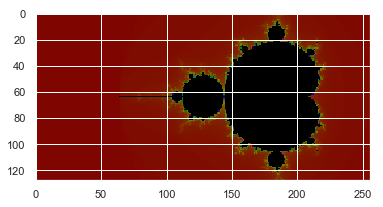

In [9]:
# Plotting the image of the projects of all the function evaluations
plt.figure()
plt.imshow(img)
plt.show()

# Basic Genetic Algorithm

Code adopted from https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6

In [ ]:
import numpy

def cal_pop_fitness(equation_inputs, pop):
    fitness = numpy.sum(pop*equation_inputs, axis=1)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    crossover_point = numpy.uint8(offspring_size[1]/2)
    
    @python_app
    def update_offspring(k, parents, crossover_point):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        a = parents[parent1_idx, 0:crossover_point]
        b = parents[parent2_idx, crossover_point:]
        return a,b
    
    output_list = []
    for k in range(offspring_size[0]):
        output_list.append(update_offspring(k, parents, crossover_point))
    
    output_list = [i.result() for i in output_list]
    
    for k in range(offspring_size[0]):
        offspring[k, 0:crossover_point] = output_list[k][0]
        offspring[k, crossover_point:] = output_list[k][1]

    return offspring

def mutation(offspring_crossover):
    
    @python_app
    def update_offpsring_crossover(value):
        import numpy
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        return value + random_value
    
    output_list = []
    
    for idx in range(offspring_crossover.shape[0]):
        offspring_crossover[idx, 4] = update_offpsring_crossover(offspring_crossover[idx, 4])
        
    offspring_crossover[idx, 4] = [i.result() for i in offspring_crossover[idx, 4]]
    return offspring_crossover

In [ ]:
import numpy

equation_inputs = [4,-2,3.5,5,-11,-4.7]
num_weights = 6
sol_per_pop = 8
num_parents_mating = 4

pop_size = (sol_per_pop,num_weights)
new_population = numpy.random.uniform(low=-4.0, high=4.0, size=pop_size)

num_generations = 5

for generation in range(num_generations):
    print("Generation : ", generation)

    fitness = cal_pop_fitness(equation_inputs, new_population)
    parents = select_mating_pool(new_population, fitness, num_parents_mating)

    offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], num_weights))
    offspring_mutation = mutation(offspring_crossover)

    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    print("Best result : ", numpy.max(numpy.sum(new_population*equation_inputs, axis=1)))


fitness = cal_pop_fitness(equation_inputs, new_population)
best_match_idx = numpy.where(fitness == numpy.max(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])